In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:20<00:00, 8.40MB/s] 


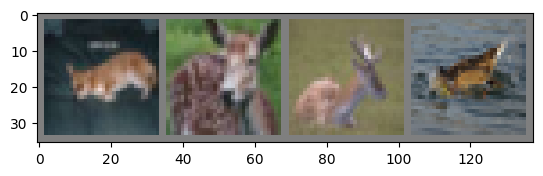

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = next(image_iter)
imshow(torchvision.utils.make_grid(images[:4]))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [6]:
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Res2NetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scales=4, stride=1, bottleneck_width=4):
        super(Res2NetBlock, self).__init__()
        self.scales = scales
        self.bottleneck_width = bottleneck_width
        
        # 计算每个尺度的卷积通道数
        self.d = out_channels // scales
        
        # 定义每个尺度的卷积
        self.convs = nn.ModuleList()
        for i in range(scales):
            in_ch = in_channels if i == 0 else self.d
            out_ch = self.d if i < scales - 1 else out_channels
            self.convs.append(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
            )
        
        # 批归一化和激活
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # 计算每个尺度的卷积
        out = [conv(x) for conv in self.convs]
        
        # 合并各个尺度的输出
        out = torch.cat(out, dim=1)
        
        # 批归一化和激活
        out = self.bn(out)
        out = self.relu(out)
        
        return out


In [8]:
class Res2Net(nn.Module):
    def __init__(self, num_classes=10, scales=4, bottleneck_width=4):
        super(Res2Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 更正层次之间通道数的配置
        self.layer1 = self._make_layer(64, 64, scales, bottleneck_width, num_blocks=3)
        self.layer2 = self._make_layer(64, 128, scales, bottleneck_width, num_blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, scales, bottleneck_width, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, scales, bottleneck_width, num_blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, scales, bottleneck_width, num_blocks, stride=1):
        layers = []
        layers.append(Res2NetBlock(in_channels, out_channels, scales, stride, bottleneck_width))
        for _ in range(1, num_blocks):
            layers.append(Res2NetBlock(out_channels, out_channels, scales, 1, bottleneck_width))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [9]:
net = Res2Net(num_classes=10, scales=4, bottleneck_width=4)
print(net)

Res2Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Res2NetBlock(
      (convs): ModuleList(
        (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1-2): 2 x Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Res2NetBlock(
      (convs): ModuleList(
        (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1-2): 2 x Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): Conv2d(16, 64, kernel_size=(3, 3), stride=

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Res2Net Block
class Res2NetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, scale=4, width=26):
        super(Res2NetBlock, self).__init__()
        self.scale = scale
        self.width = width
        self.mid_channels = width * scale

        self.conv1 = nn.Conv2d(in_channels, self.mid_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(self.mid_channels)
        self.relu = nn.ReLU(inplace=True)

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(scale - 1):
            self.convs.append(nn.Conv2d(width, width, kernel_size=3, padding=1, bias=False))
            self.bns.append(nn.BatchNorm2d(width))

        self.conv3 = nn.Conv2d(self.mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        split_size = self.width
        spx = torch.split(out, split_size, 1)
        ys = []
        ys.append(spx[0])
        for i in range(1, self.scale):
            ys.append(self.relu(self.bns[i-1](self.convs[i-1](spx[i])) + ys[i-1]))

        out = torch.cat(ys, 1)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Res2Net Model
class Res2Net(nn.Module):
    def __init__(self, block, layers, num_classes=10, scale=4, width=26):
        super(Res2Net, self).__init__()
        self.in_channels = 64
        self.scale = scale
        self.width = width

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

        # 初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, scale=self.scale, width=self.width))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, scale=self.scale, width=self.width))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 数据预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.5, 0.5, 0.5)),
])

# 加载数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Res2Net(Res2NetBlock, [3, 3, 3], num_classes=10, scale=4, width=16).to(device)
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

# 训练和测试函数
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        train_loss += loss.item()
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    loss = train_loss / batch_idx
    print('Epoch: %d, train loss: %.6f, acc: %.3f%% (%d/%d)' % (epoch, loss, acc, correct, total))

def test(epoch):
    model.eval()
    total = 0
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    avg_loss = test_loss / len(testloader)
    acc = 100. * correct / total
    print('Epoch:Test Loss: %.6f | Acc: %.3f%% (%d/%d)' % (avg_loss, acc, correct, total))
    return avg_loss

# 训练循环
for epoch in range(50):
    train(epoch)
    test_loss =test(epoch)
    scheduler.step(test_loss, epoch=epoch)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0, train loss: 1.790485, acc: 33.716% (16858/50000)
Epoch:Test Loss: 1.390998 | Acc: 48.500% (4850/10000)


/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:1013: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1, train loss: 1.240648, acc: 54.906% (27453/50000)
Epoch:Test Loss: 1.429329 | Acc: 50.230% (5023/10000)
Epoch: 2, train loss: 1.024425, acc: 63.442% (31721/50000)
Epoch:Test Loss: 1.170635 | Acc: 59.110% (5911/10000)
Epoch: 3, train loss: 0.910826, acc: 67.510% (33755/50000)
Epoch:Test Loss: 1.050989 | Acc: 64.320% (6432/10000)
Epoch: 4, train loss: 0.826312, acc: 70.826% (35413/50000)
Epoch:Test Loss: 1.210453 | Acc: 63.300% (6330/10000)
Epoch: 5, train loss: 0.748749, acc: 73.788% (36894/50000)
Epoch:Test Loss: 0.831807 | Acc: 71.270% (7127/10000)
Epoch: 6, train loss: 0.718241, acc: 75.140% (37570/50000)
Epoch:Test Loss: 0.944607 | Acc: 69.720% (6972/10000)
Epoch: 7, train loss: 0.688455, acc: 76.098% (38049/50000)
Epoch:Test Loss: 1.294273 | Acc: 62.270% (6227/10000)
Epoch: 8, train loss: 0.665275, acc: 77.022% (38511/50000)
Epoch:Test Loss: 1.130460 | Acc: 64.500% (6450/10000)
Epoch: 9, train loss: 0.651522, acc: 77.612% (38806/50000)
Epoch:Test Loss: 0.936901 | Acc: 69.7